In [1]:
import sys
import os
from pathlib import Path

# 1. Correct Path Resolution
# If this notebook is in 'notebooks/', parents[1] points to the project root 'churn_prediction/'
try:
    repo_root = Path(__file__).resolve().parents[1]
except NameError:
    # Fallback for interactive environments like Jupyter/VS Code
    repo_root = Path(os.getcwd()).resolve().parent

In [2]:
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from src.utils.logger import get_logger
from src.visualization.plots import (
    plot_missing_matrix,
    plot_distribution_comparison,
)

logger = get_logger(__name__)


In [4]:
# %%% [markdown]
# ## 1️⃣ Load the artefacts produced by the preprocessing script
# 
# * `data/interim/cleaned.csv` – Standardized labels and basic cleaning.
# * `data/processed/*.parquet` – Final engineered features and 1/0 targets.

# %%% [code]
DATA_ROOT = repo_root / "data"

# Load Cleaned Data
cleaned_path = DATA_ROOT / "interim" / "cleaned.csv"
if not cleaned_path.exists():
    logger.error("Cleaned CSV missing. Run 'python -m src.data.preprocess_and_save' first.")
else:
    df_cleaned = pd.read_csv(cleaned_path)
    logger.info(f"Cleaned CSV loaded. Shape: {df_cleaned.shape}")

2026-01-09 14:08:42,014 - __main__ - INFO - Cleaned CSV loaded. Shape: (7043, 20)


In [5]:
# Load Processed X/y (Train set)
X_train_path = DATA_ROOT / "processed" / "X_train.parquet"
y_train_path = DATA_ROOT / "processed" / "y_train.parquet"

X_train = pd.read_parquet(X_train_path)
# Ensure target is mapped correctly for visualization
y_train = pd.read_parquet(y_train_path)["Churn"].map({"Yes": 1, "No": 0}).fillna(0).astype(int)

2026-01-09 14:08:42,103 - __main__ - INFO - Processed X_train shape: (5634, 32)


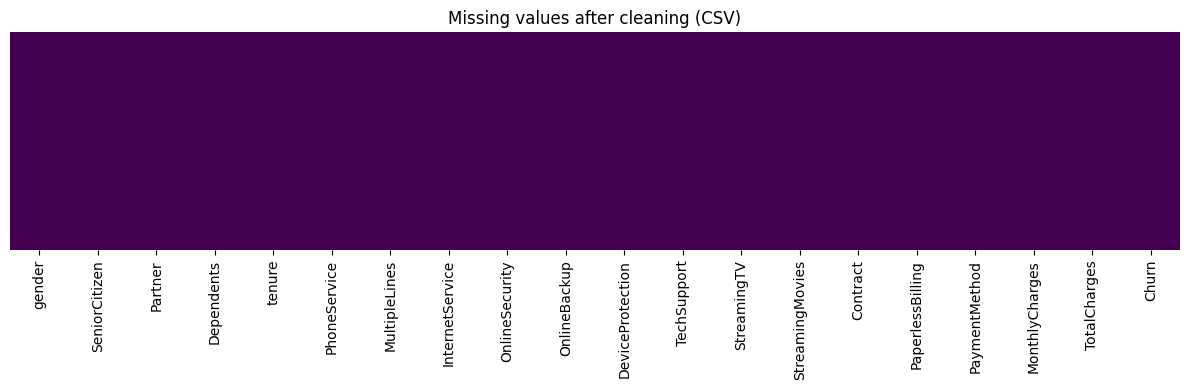

In [6]:
logger.info(f"Processed X_train shape: {X_train.shape}")

# %%% [markdown]
# ## 2️⃣ Sanity‑check on missing values
# 
# After cleaning, the dataset should have zero missing values.

# %%% [code]
# Visualizing missingness heatmap
plot_missing_matrix(df_cleaned, title="Missing values after cleaning (CSV)")

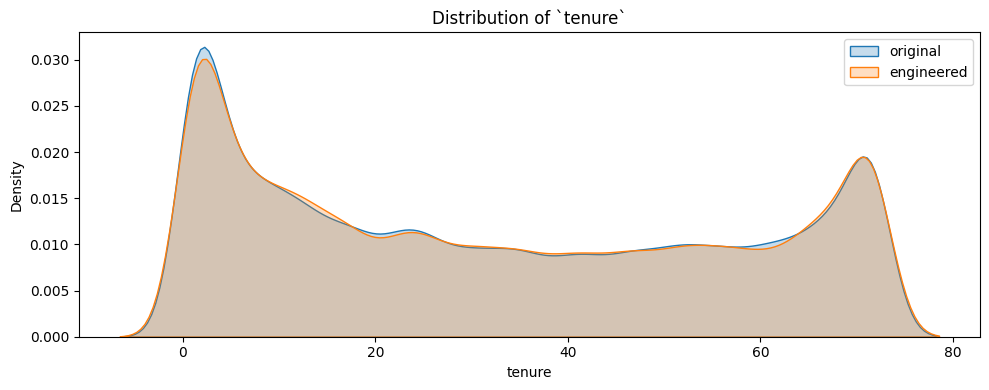

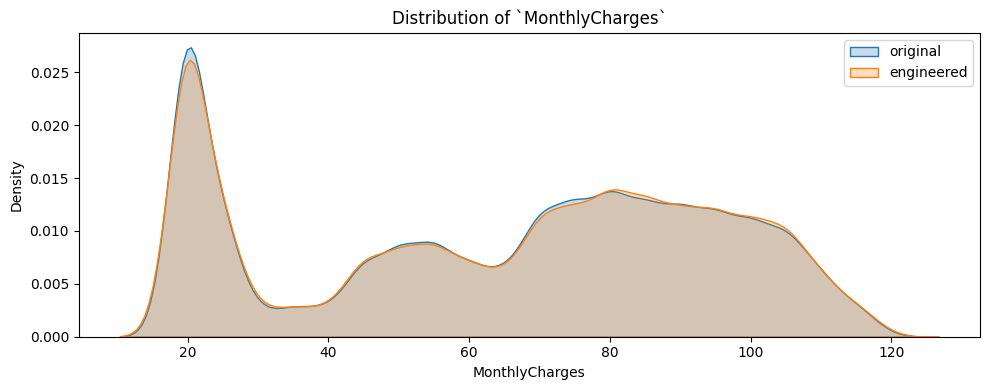

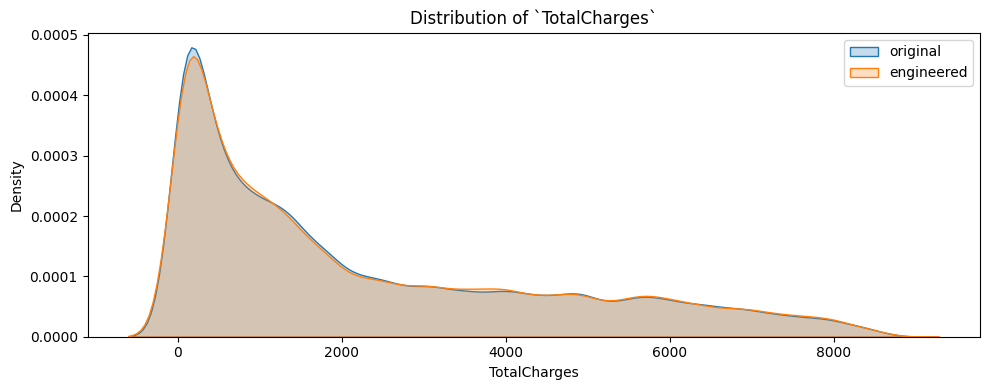

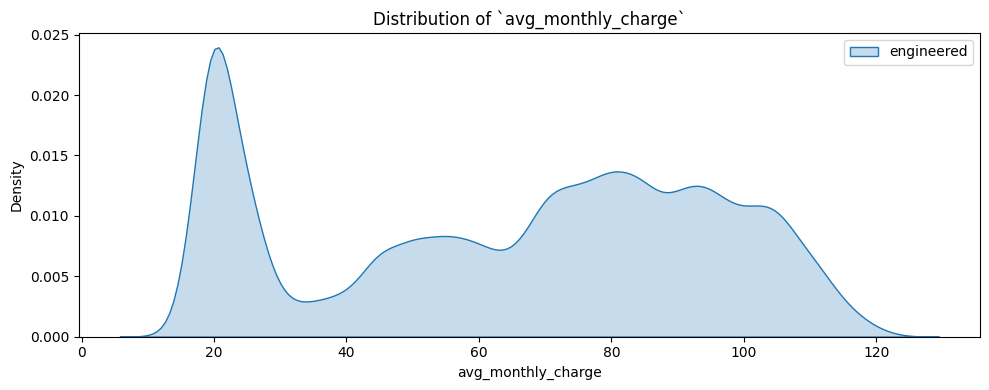

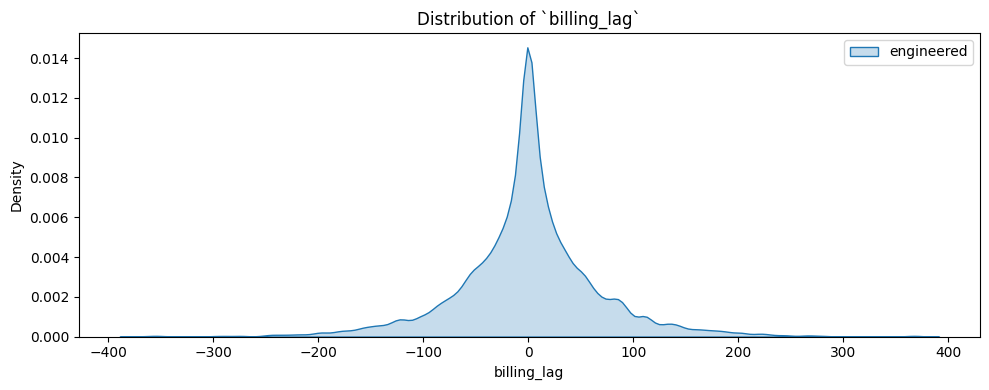

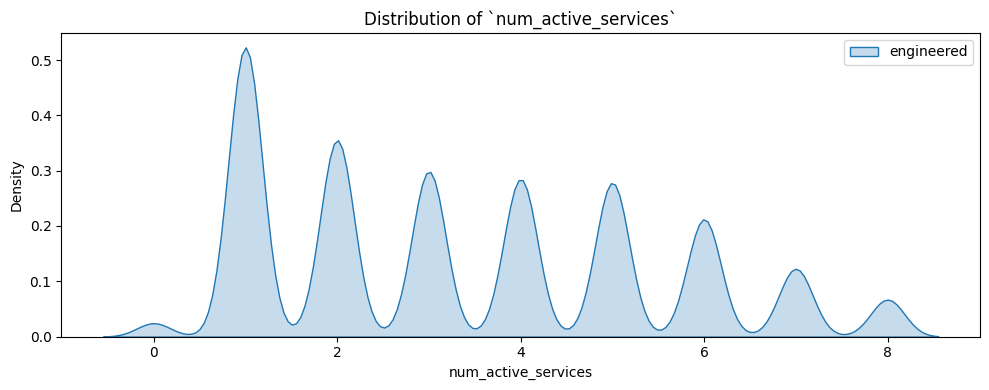

In [7]:
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
engineered_cols = ["avg_monthly_charge", "billing_lag", "num_active_services"]

for col in numeric_cols + engineered_cols:
    if col in X_train.columns:
        # Use our plotting helper from src.visualization.plots
        plot_distribution_comparison(
            original=df_cleaned[col] if col in df_cleaned.columns else None,
            engineered=X_train[col],
            col_name=col
        )
    else:
        logger.warning(f"Column `{col}` not found in X_train.")

In [8]:
# Create the sample
sample = X_train.sample(5, random_state=42).copy()

# Map the 0/1 target back to readable labels
sample["Churn"] = y_train.loc[sample.index].map({1: "Yes", 0: "No"})

# Display the result
display(sample)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,is_two_year_contract,has_internet_service,is_senior,num_active_services,pay_electronic_check,pay_mailed_check,pay_bank_transfer_automatic,pay_credit_card_automatic,billing_lag,Churn
2121,Male,No,Yes,No,51,Yes,Yes,DSL,No,No,...,1,1,0,5,0,0,1,0,66.05,No
915,Female,No,No,No,11,Yes,No,DSL,Yes,No,...,0,1,0,3,0,1,0,0,17.25,No
2585,Female,No,No,No,16,Yes,No,No,No internet service,No internet service,...,0,0,0,1,0,0,1,0,-3.00,No
787,Female,No,No,No,34,Yes,Yes,DSL,No,No,...,0,1,0,4,0,1,0,0,-52.50,No
101,Female,Yes,Yes,No,43,Yes,Yes,Fiber optic,No,No,...,0,1,1,6,1,0,0,0,-90.75,No
